In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
import shutil
from google.colab import drive
drive.mount('/content/drive') # Monter Google Drive

from PIL import Image, ImageFilter, ImageEnhance # Pour le prétraitement des images
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50 # Importer ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


Mounted at /content/drive


### Importation de la base de données Scene Classification: Images and Audio

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/scene-classification-images-and-audio")


100%|██████████| 1.61G/1.61G [01:31<00:00, 18.9MB/s]

Extracting files...


Visualisation des données

In [ ]:
# Dossier images contient les scènes
# Fichier csv contient les caractéristiques mffc de chaque image
os.listdir(path)

['images', 'dataset.csv']

### Prétraitement et extraction des caractéristiques des données : images

#### Cette fonction traite une image en effectuant plusieurs étapes :
  1. Vérification et redimensionnement : si l'image n'est pas de taille 224x224
  2. Réduction de bruit : un filtre médian est appliqué avec une fenêtre de taille 3.
  3. Augmentation du contraste : le contraste de l'image est amplifié avec un facteur de 1.5.
  4. Normalisation : les pixels de l'image sont normalisés dans l'intervalle [0, 1].
- La fonction retourne l'image traitée sous forme d'un tableau numpy normalisé.

In [ ]:
def process_image(image_path):

    # On ouvre l'image
    with Image.open(image_path) as img:

        # On test si l'image est déjà de taille 224x224
        if img.size == (30, 30):
            img_resized = img
        else:
            # Étape 1 : Redimensionnement à 224x224 pixels
            img_resized = img.resize((30, 30))

        # Étape 2 : Réduction de bruit ( Un filtre median avec fenêtre de taille 3)
        img_denoised = img_resized.filter(ImageFilter.MedianFilter(size=1))

        # Étape 3 : Augmentation du contraste
        enhancer = ImageEnhance.Contrast(img_denoised)
        img_contrasted = enhancer.enhance(0.5)  # Facteur de contraste

        # Étape 4 : Normalisation des pixels
        img_array = np.asarray(img_contrasted) / 255.0  # Normalisation [0, 1]

        return img_array

#### Extraction des caractéristiques des images

##### 1- On utilise un modèle VGG19 préentraîné avec les poids d'ImageNet pour extraire les caractéristiques des images

Charger le modèle VGG19

In [ ]:
# Chemin du modèle sur Google Drive
model_path = '/content/drive/My Drive/vgg19_weights.h5'  # Le chemin que vous avez choisi à l'étape 2

# Charger le modèle
base_model = VGG19(weights=None)  # Initialiser sans poids
base_model.load_weights(model_path)  # Charger les poids depuis Google Drive

Mounted at /content/drive


La couche "fc2" est l'une des dernières couches denses du modèle, avant la sortie finale (la couche "fc3" ou de classification).

In [ ]:
# Pour extraire les caractéristiques de la couche avant la dernière (couche dense), nous utilisons 'fc2'
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

##### 2- On utilise un modèle ResNet50 préentraîné avec les poids d'ImageNet pour extraire les caractéristiques des images

Charger le modèle ResNet pré-entraîné

In [ ]:
# Charger le modèle ResNet50 pré-entraîné (175 couches)
base_model = ResNet50(weights='imagenet', include_top=False) # include_top=False pour exclure la couche de classification

# Créer un nouveau modèle sans la couche de sortie
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output) # La couche -2 est l'avant-dernière couche du modèle de base

# Résumé du nouveau modèle
# model.summary()

##### 3- On utilise un modèle InceptionV3 préentraîné avec les poids d'ImageNet pour extraire les caractéristiques des images

Charger le modèle InceptionV3 pré-entraîné

In [ ]:
# Charger le modèle InceptionV3 pré-entraîné
base_model = InceptionV3(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)  # La couche -2 est l'avant-dernière couche (avg_pool)

##### 4- Partie commune (Extraction des caractéristiques des images) :

Extraire les caractéristiques de chaque image

In [ ]:
scenes_folder = os.path.join(path, 'images') # Dossier qui regroupe les scènes
scenes = os.listdir(scenes_folder) # Liste des scènes
scenes.sort() # Trier la liste par ordre alphabétique
print(scenes) # Afficher la liste

['beach', 'beach2', 'beach3', 'beach4', 'classroom1', 'classroom2', 'classroom3', 'classroom4', 'classroom5', 'classroom6', 'edinburgh', 'football1', 'football2', 'football3', 'football4', 'forest', 'forest3', 'guangzhou', 'jungle', 'jungle2', 'london', 'newyork', 'restaurant1', 'restaurant2', 'restaurant3', 'restaurant4', 'restaurant5', 'restaurant6', 'restaurant7', 'restaurant8', 'river1', 'river2', 'river3', 'river4', 'river5', 'river6', 'river7', 'river8', 'store1', 'store2', 'store3', 'store4', 'vegas', 'venice', 'village1']


In [ ]:
scenes_data = pd.DataFrame() # DataFrame qui va contenir les caractéristiques des images

for scene in scenes:

    print(f'Traitement des images de la scène : {scene}')

    scene_folder = os.path.join(scenes_folder, scene) # Dossier de la scene
    list_images = os.listdir(scene_folder) # Liste des images de cette scene

    # Construction des chemins d'images
    list_images = [os.path.join(scene_folder, image) for image in list_images]
    list_images.sort()

    for image_path in list_images:

        image_processed = process_image(image_path)

        # Ajoute d'une dimension batch (le modèle attend un tableau de forme (batch_size, height, width, channels))
        image_array = np.expand_dims(image_processed, axis=0)

        # Extraction des caractéristiques de l'image via le modèle
        caracteristiques = model.predict(image_array, verbose=0)  # verbose=0 désactive la barre de progression

        # Aplatir le vecteur de caractéristiques
        caracteristiques = caracteristiques.flatten()

        # Ajout du nom de la scène (classe) comme première colonne et le nom de l'image
        row_data = pd.DataFrame([[scene] + [image_path.replace('\\', '/').split('/')[-1]] + caracteristiques.tolist()])

        # Ajoute de ligne data à la DataFrame
        scenes_data = pd.concat([scenes_data, row_data])

# Renommer les colonnes
scenes_data.columns = ['SubClass', 'IMAGE'] + [f'Feature_{i}' for i in range(scenes_data.shape[1] - 2)]

# 430 images <==> 15 min

Enregistrer les caractéristiques extraites

In [ ]:
scenes_data.to_csv(os.path.join(path, "images_features_resnet.csv"), index=False)
os.listdir(os.path.join(path))

# Copie du fichier vers Google Drive
!cp "{os.path.join(path, 'images_features_resnet.csv')}" "/content/drive/My Drive/Multimodale/Data_Features"


Charger les caractéristiques depuis Google Drive

In [ ]:
# Chemin d'accès au fichier sur Google Drive
file_path = '/content/drive/My Drive/Multimodale/Data_Features/images_features.csv'

# Charger le fichier dans un DataFrame pandas
scenes_data = pd.read_csv(file_path)

# Aafficher les premières lignes
scenes_data.head()

,SubClass,IMAGE,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,...,C_4086,C_4087,C_4088,C_4089,C_4090,C_4091,C_4092,C_4093,C_4094,C_4095
0,beach,beach0.png,0.538444,0.0,0.463963,0.028087,1.296627,0.921912,0.0,0.0,...,0.038778,0.904302,0.992052,0.869632,0.0,0.0,0.0,0.0,0.325832,0.090953
1,beach,beach1.png,0.478749,0.0,0.473210,0.054322,1.282259,0.920567,0.0,0.0,...,0.085440,0.813594,0.995918,0.787818,0.0,0.0,0.0,0.0,0.302753,0.100030
2,beach,beach10.png,0.385724,0.0,0.556242,0.000000,1.229769,0.983087,0.0,0.0,...,0.152053,0.868707,1.031767,0.771014,0.0,0.0,0.0,0.0,0.240575,0.052493
3,beach,beach100.png,0.518872,0.0,0.564591,0.000000,1.280057,0.901700,0.0,0.0,...,0.062651,0.821810,1.018209,0.728661,0.0,0.0,0.0,0.0,0.272786,0.080897
4,beach,beach101.png,0.549013,0.0,0.554230,0.000000,1.282579,0.902930,0.0,0.0,...,0.069760,0.803324,1.024356,0.739038,0.0,0.0,0.0,0.0,0.264427,0.075939


In [ ]:
# Nombre total de colonnes dans scenes_data
num_columns = len(scenes_data.columns)
print(num_columns)

num_rows = scenes_data.shape[0]  # 0 pour le nombre de lignes, 1 pour le nombre de colonnes
print(num_rows)

4098
17252


### Prétraitement des caractéristiques mfcc: audio

#### Importation des données auditives

In [ ]:
mfcc_features = pd.read_csv(os.path.join(path, 'dataset.csv'))

In [ ]:
# les cinq premiers lignes
mfcc_features.tail(5)

,IMAGE,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104,CLASS1,CLASS2
17247,images/store4/store4-1026.png,14.239928,24.677429,-16.642587,-16.333397,28.834652,-48.712410,45.642448,-21.947515,-3.759865,...,-40.159954,30.120032,-13.060526,-9.219403,12.475126,-22.601245,17.750249,-15.017793,INDOORS,GROCERY-STORE
17248,images/store4/store4-1027.png,14.718721,1.950969,-12.385012,-11.159338,-9.408496,-6.195532,-5.524698,-3.498479,1.615768,...,-52.602034,24.761429,-27.102315,-3.128097,27.192930,-32.536263,24.921965,-13.841536,INDOORS,GROCERY-STORE
17249,images/store4/store4-1028.png,14.600713,4.169370,-8.191752,-10.247319,-17.536838,-12.626182,-10.417944,2.356240,-1.213015,...,-31.669516,23.663856,-8.380984,5.988465,6.474730,-20.457587,-16.162687,-10.610574,INDOORS,GROCERY-STORE
17250,images/store4/store4-1029.png,14.319269,18.059742,-13.402903,-13.233159,14.580749,-42.086968,14.006702,-18.285120,-4.757876,...,-20.178121,22.866183,-14.766197,-4.440472,13.921726,-16.048833,4.011102,0.031063,INDOORS,GROCERY-STORE
17251,images/store4/store4-1030.png,14.150456,2.506630,-8.436129,-8.280871,-12.001908,2.700066,0.029298,-4.737745,-4.447416,...,-47.612023,37.086938,-26.782493,-17.047327,6.179108,-20.238054,19.269190,-5.813571,INDOORS,GROCERY-STORE


## ***Architecture 2 : Fusion précoce***

####**1. Extraction de caractéristiques audio avec un LSTM:**
On utilise un réseau LSTM pour extraire des caractéristiques à partir de données audio représentées par des MFCC. L'objectif est de transformer les 104 caractéristiques MFCC en un vecteur de caractéristiques plus compact et informatif, de 64 dimensions.

In [ ]:
# 1. Charger les données du fichier CSV
mfcc_features = pd.read_csv(os.path.join(path, 'dataset.csv'))

# 2. Préparer les données pour le LSTM
# Sélectionner les colonnes contenant les caractéristiques MFCC
X = mfcc_features.iloc[:, 1:105].values  # Colonnes mfcc_1 à mfcc_104

# Redimensionner les données pour le LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

# 3. Créer le modèle LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))  # Une couche LSTM
model.add(Dense(64, activation='relu'))  # Une couche Dense pour la réduction de dimension

# 4. Extraire les caractéristiques
features = model.predict(X)

# 5. Créer un DataFrame avec les nouvelles caractéristiques
audios_features = pd.DataFrame(
    data=np.c_[mfcc_features['CLASS2'],  # Label (main class)
              mfcc_features['IMAGE'].str.extract(r'images/([a-z0-9]+)/')[0],  # SubClass
              mfcc_features['IMAGE'].apply(lambda x: x.split('/')[-1]),  # IMAGE
              features],
    columns=['Label', 'SubClass', 'IMAGE'] + [f'feature_{i}' for i in range(features.shape[1])]
)

# 6. Enregistrer le DataFrame dans un fichier CSV
audios_features.to_csv(os.path.join(path, "audios_features.csv"), index=False)

# Copier le fichier dans Google Drive
drive.mount('/content/drive')
source_path = os.path.join(path, "audios_features.csv")
destination_path = "/content/drive/My Drive/Multimodale/Data_Features/audios_features.csv"
shutil.copy(source_path, destination_path)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Multimodale/Data_Features/audios_features.csv'

In [ ]:
# Chemin du fichier sur Google Drive
file_path = '/content/drive/My Drive/Multimodale/Data_Features/audios_features.csv'

# Charger le fichier dans un DataFrame pandas
audios_features_df = pd.read_csv(file_path)

# Afficher les premières lignes
audios_features_df.head()

,Label,SubClass,IMAGE,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,FOREST,forest,forest0.png,0.098722,0.000000,0.0,0.266995,0.0,0.604112,0.0,...,0.083809,0.000000,0.155769,0.000000,0.392649,0.404254,0.335206,0.180659,0.000000,0.358419
1,FOREST,forest,forest1.png,0.519325,0.000000,0.0,0.356544,0.0,1.147089,0.0,...,0.000000,0.504670,0.405955,0.467922,0.344288,0.093796,0.738429,0.101215,0.000000,0.041580
2,FOREST,forest,forest2.png,0.000000,0.401638,0.0,0.640012,0.0,0.228058,0.0,...,0.103851,0.000000,0.000000,0.000000,0.959596,1.090038,0.371306,0.000000,0.000000,0.662682
3,FOREST,forest,forest3.png,0.000000,0.000000,0.0,0.688969,0.0,0.949568,0.0,...,0.400116,0.000000,0.042132,0.000000,0.216583,0.391978,0.000000,0.000000,0.000000,0.340741
4,FOREST,forest,forest4.png,0.342916,0.000000,0.0,0.096814,0.0,0.315124,0.0,...,0.000000,0.016161,0.292937,0.000000,0.066487,0.000000,0.447823,0.000000,0.203651,0.499455


In [ ]:
# Nombre de classes
num_classes = audios_features_df['SubClass'].nunique()
print(f"Nombre de classes: {num_classes}")

# Nombre d'images par classe
images_per_class = audios_features_df['SubClass'].value_counts().sort_index()
print("\nNombre d'images par classe:")
print(images_per_class)

# Nombre total de lignes
num_rows = audios_features_df.shape[0]
print(f"\nNombre total de lignes dans le fichier: {num_rows}")

Nombre de classes: 45

Nombre d'images par classe:
SubClass
beach           240
beach2          240
beach3          760
beach4          840
classroom1       90
classroom2      240
classroom3      118
classroom4      715
classroom5      690
classroom6      900
edinburgh       333
football1       500
football2       243
football3       317
football4       540
forest          240
forest3        1121
guangzhou       600
jungle          414
jungle2         990
london          199
newyork         240
restaurant1     186
restaurant2     123
restaurant3     186
restaurant4     113
restaurant5      40
restaurant6      69
restaurant7     420
restaurant8     322
river1          205
river2          230
river3           54
river4          197
river5          245
river6          340
river7          733
river8           80
store1          160
store2          680
store3          208
store4         1031
vegas           240
venice          634
village1        186
Name: count, dtype: int64

Nombre total 

In [ ]:
# Chemin du fichier sur Google Drive
file_path = '/content/drive/My Drive/Multimodale/Data_Features/images_features.csv'
file_path = '/content/drive/My Drive/Multimodale/Data_Features/images_features_inception.csv'
file_path = '/content/drive/My Drive/Multimodale/Data_Features/images_features_resnet.csv'

# Charger le fichier dans un DataFrame pandas
images_features_df = pd.read_csv(file_path)

# Afficher les premières lignes
images_features_df.head()

,SubClass,IMAGE,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,...,Feature_2690,Feature_2691,Feature_2692,Feature_2693,Feature_2694,Feature_2695,Feature_2696,Feature_2697,Feature_2698,Feature_2699
0,beach,beach0.png,0.666667,0.686275,0.745098,0.662745,0.686275,0.745098,0.654902,0.678431,...,0.643137,0.611765,0.607843,0.650980,0.611765,0.607843,0.647059,0.607843,0.603922,0.643137
1,beach,beach1.png,0.662745,0.686275,0.745098,0.662745,0.686275,0.745098,0.658824,0.678431,...,0.478431,0.592157,0.529412,0.482353,0.592157,0.529412,0.486275,0.592157,0.529412,0.490196
2,beach,beach10.png,0.450980,0.462745,0.435294,0.564706,0.584314,0.607843,0.662745,0.686275,...,0.482353,0.607843,0.545098,0.490196,0.603922,0.545098,0.494118,0.603922,0.545098,0.498039
3,beach,beach100.png,0.686275,0.709804,0.764706,0.686275,0.709804,0.764706,0.694118,0.713726,...,0.501961,0.631373,0.564706,0.501961,0.631373,0.564706,0.509804,0.627451,0.568627,0.521569
4,beach,beach101.png,0.690196,0.709804,0.764706,0.682353,0.705882,0.760784,0.690196,0.713726,...,0.505882,0.635294,0.568627,0.505882,0.635294,0.568627,0.505882,0.631373,0.568627,0.505882


In [ ]:
# On ajoute la colonne 'Label' à images_features_df en utilisant la correspondance depuis audios_features_df
noms_images_audio = audios_features_df['IMAGE']
image_vers_classe = dict(zip(noms_images_audio, audios_features_df['Label']))
images_features_df['Label'] = images_features_df['IMAGE'].map(image_vers_classe)
images_features_df = images_features_df[['Label', 'SubClass', 'IMAGE'] + [col for col in images_features_df.columns if col not in ['Label', 'SubClass', 'IMAGE']]]

images_features_df.head()

,Label,SubClass,IMAGE,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,...,Feature_2690,Feature_2691,Feature_2692,Feature_2693,Feature_2694,Feature_2695,Feature_2696,Feature_2697,Feature_2698,Feature_2699
0,BEACH,beach,beach0.png,0.666667,0.686275,0.745098,0.662745,0.686275,0.745098,0.654902,...,0.643137,0.611765,0.607843,0.650980,0.611765,0.607843,0.647059,0.607843,0.603922,0.643137
1,BEACH,beach,beach1.png,0.662745,0.686275,0.745098,0.662745,0.686275,0.745098,0.658824,...,0.478431,0.592157,0.529412,0.482353,0.592157,0.529412,0.486275,0.592157,0.529412,0.490196
2,BEACH,beach,beach10.png,0.450980,0.462745,0.435294,0.564706,0.584314,0.607843,0.662745,...,0.482353,0.607843,0.545098,0.490196,0.603922,0.545098,0.494118,0.603922,0.545098,0.498039
3,BEACH,beach,beach100.png,0.686275,0.709804,0.764706,0.686275,0.709804,0.764706,0.694118,...,0.501961,0.631373,0.564706,0.501961,0.631373,0.564706,0.509804,0.627451,0.568627,0.521569
4,BEACH,beach,beach101.png,0.690196,0.709804,0.764706,0.682353,0.705882,0.760784,0.690196,...,0.505882,0.635294,0.568627,0.505882,0.635294,0.568627,0.505882,0.631373,0.568627,0.505882


In [ ]:
# Nombre de classes
num_classes = images_features_df['Label'].nunique()
print(f"Nombre de classes: {num_classes}")

# Nombre d'images par classe
images_per_class = images_features_df['Label'].value_counts().sort_index()
print("\nNombre d'images par classe:")
print(images_per_class)

# Nombre total de lignes
num_rows = images_features_df.shape[0]
print(f"\nNombre total de lignes dans le fichier: {num_rows}")

Nombre de classes: 9

Nombre d'images par classe:
Label
BEACH             2080
CITY              2432
CLASSROOM         2753
FOOTBALL-MATCH    1600
FOREST            1361
GROCERY-STORE     2079
JUNGLE            1404
RESTAURANT        1459
RIVER             2084
Name: count, dtype: int64

Nombre total de lignes dans le fichier: 17252


#### **2. Combinaison des caractéristiques:**
Avant tout entraînement, les caractéristiques extraites des images et des audios sont fusionnées en un seul vecteur. Ceci permet à un modèle unique d'apprendre simultanément à partir des données visuelles et auditives, ce qui constitue la base de la fusion précoce.

In [ ]:
# Fusionner les DataFrames en utilisant 'IMAGE' comme clé
combined_df = pd.merge(images_features_df, audios_features_df, on=['Label', 'SubClass','IMAGE'], how='inner')

# Trier combined_df par Label et SubClass dans l'ordre alphabétique
combined_df = combined_df.sort_values(by=['Label', 'SubClass'], ascending=[True, True])

# Afficher les premières lignes du DataFrame fusionné
combined_df.head()

,Label,SubClass,IMAGE,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,BEACH,beach,beach0.png,0.666667,0.686275,0.745098,0.662745,0.686275,0.745098,0.654902,...,0.335376,0.000000,0.000000,0.014135,0.672928,0.125935,0.210799,0.000000,0.000000,0.169178
1,BEACH,beach,beach1.png,0.662745,0.686275,0.745098,0.662745,0.686275,0.745098,0.658824,...,0.000000,0.069877,0.120306,0.216792,0.945109,0.000000,0.828891,0.000000,0.134276,0.117310
2,BEACH,beach,beach10.png,0.450980,0.462745,0.435294,0.564706,0.584314,0.607843,0.662745,...,0.000000,0.179926,0.000000,0.038148,0.976591,0.114330,0.885398,0.000000,0.000000,0.170671
3,BEACH,beach,beach100.png,0.686275,0.709804,0.764706,0.686275,0.709804,0.764706,0.694118,...,0.074421,0.418189,0.533106,0.235142,0.798533,0.217088,0.600934,0.000000,0.000000,0.207440
4,BEACH,beach,beach101.png,0.690196,0.709804,0.764706,0.682353,0.705882,0.760784,0.690196,...,0.000000,0.664844,0.000000,0.000000,0.269964,0.023534,0.596322,0.155184,0.000000,0.211958


In [ ]:
# Nombre de classes
num_classes = combined_df['Label'].nunique() # Modifier "Label" par "SubClass"
print(f"Nombre de classes : {num_classes}")

# Nombre d'images par classe
images_per_class = combined_df['Label'].value_counts().sort_index() # Modifier "Label" par "SubClass"
print("\nNombre d'images par classe :")
print(images_per_class)

# Nombre total de lignes
num_rows = combined_df.shape[0]
print(f"\nNombre total de lignes dans le fichier : {num_rows}")

Nombre de classes : 9

Nombre d'images par classe :
Label
BEACH             2080
CITY              2432
CLASSROOM         2753
FOOTBALL-MATCH    1600
FOREST            1361
GROCERY-STORE     2079
JUNGLE            1404
RESTAURANT        1459
RIVER             2084
Name: count, dtype: int64

Nombre total de lignes dans le fichier : 17252


In [ ]:
# Diviser les données en ensembles d'entraînement et de test
# Nous prenons 2/3 et 1/3 pour chaque SubClass et non pas pour l'ensemble des données
# afin de garantir la diversité des données dans les deux ensembles.
train_df, test_df = train_test_split(combined_df, test_size=1/3, stratify=combined_df['SubClass'], random_state=42)

print("Forme du DataFrame d'entraînement :", train_df.shape)
print("Forme du DataFrame de test :", test_df.shape)

# 11501 images d'entraînement et (4160 = 4096 + 64) caractéristiques pour chaque image
# 5751 images de test et (4160 = 4096 + 64) caractéristiques pour chaque image.

Forme du DataFrame d'entraînement : (11501, 2767)
Forme du DataFrame de test : (5751, 2767)


In [ ]:
# Préparer les données d'entraînement
X_train_combined = train_df.drop(['Label', 'SubClass', 'IMAGE'], axis=1)  # Caractéristiques pour l'entraînement
y_train_combined = train_df['Label']  # Variable cible pour l'entraînement

X_test_combined = test_df.drop(['Label', 'SubClass', 'IMAGE'], axis=1)  # Caractéristiques pour le test
y_test_combined = test_df['Label']  # Variable cible pour le test

print(X_train_combined.columns)

Index(['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
       'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9',
       ...
       'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58',
       'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63'],
      dtype='object', length=2764)


In [ ]:
# print(y_train)
y_train_combined

,Label
7203,FOREST
1646,BEACH
8037,FOREST
4903,CITY
11977,RESTAURANT
...,...
16876,CITY
15479,GROCERY-STORE
10728,RESTAURANT
12977,RIVER


In [ ]:
# Mettre à l'échelle les caractéristiques
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

In [ ]:
# Encoder la variable cible (target)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_combined)
y_test_encoded = label_encoder.transform(y_test_combined)

#### **3. Entraînement d'un modèle unique:**
- Au lieu d'entraîner des modèles séparés pour les images et les audios, nous entraînerons un seul modèle sur les caractéristiques combinées.
- Nous pouvons utiliser un réseau de neurones dense ou tout autre modèle adapté à la classification multiclasse

##### 3-1. Le modèle de réseau de neurones dense

In [ ]:
# Définir le modèle (par exemple, un réseau de neurones dense)
model_combined_dense = Sequential()
model_combined_dense.add(Dense(2048, activation='relu', input_shape=(X_train_combined.shape[1],)))
model_combined_dense.add(BatchNormalization())
model_combined_dense.add(Dropout(0.5))
model_combined_dense.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compiler le modèle
model_combined_dense.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model_combined_dense.fit(X_train_combined, y_train_encoded, validation_data=(X_test_combined, y_test_encoded), epochs=50, batch_size=32, verbose=1)

# Enregistrer le modèle de fusion précoce (Réseau de neurones dense)
model_combined_dense.save('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_Dense_Resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6259 - loss: 1.4918 - val_accuracy: 0.7889 - val_loss: 0.7111
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7762 - loss: 0.7939 - val_accuracy: 0.8512 - val_loss: 0.5352
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7988 - loss: 0.7096 - val_accuracy: 0.8444 - val_loss: 0.5135
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8199 - loss: 0.6202 - val_accuracy: 0.8409 - val_loss: 0.5127
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8364 - loss: 0.5869 - val_accuracy: 0.8804 - val_loss: 0.4521
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8524 - loss: 0.5388 - val_accuracy: 0.8510 - val_loss: 0.5342
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8518 - loss: 0.5123 - val_accuracy: 0.8541 - val_loss: 0.5168
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8542 - loss: 0.5208 - val_accuracy: 

In [ ]:
# Charger le modèle de fusion précoce (Réseau de neurones dense)
model_combined_dense = load_model('/content/drive/MyDrive//Multimodale/Model/Modele_Precoce_Dense.h5')
model_combined_dense = load_model('/content/drive/MyDrive//Multimodale/Model/Modele_Precoce_Dense_Inception.h5')
model_combined_dense = load_model('/content/drive/MyDrive//Multimodale/Model/Modele_Precoce_Dense_Resnet.h5')

In [ ]:
# Évaluation des prédictions sur les données de test
y_pred_combined = model_combined_dense.predict(X_test_combined)  # les probabilitées des prédictions

# Conversion des probabiltées des prédictions en classes
y_pred_classes_combined = y_pred_combined.argmax(axis=1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Calcul des métriques pour le modèle combiné
precision_combined = precision_score(y_test_encoded, y_pred_classes_combined, average='weighted')
recall_combined = recall_score(y_test_encoded, y_pred_classes_combined, average='weighted')
f1_combined = f1_score(y_test_encoded, y_pred_classes_combined, average='weighted')

# Affichage des résultats
print(f"Précision (Modèle combiné): {precision_combined}\n")
print(f"Rappel (Modèle combiné): {recall_combined}\n")
print(f"F1-Score (Modèle combiné): {f1_combined}")

Précision (Modèle combiné): 0.9073580390304669

Rappel (Modèle combiné): 0.9076682316118936

F1-Score (Modèle combiné): 0.9070581852429419


In [ ]:
# Affichage du rapport de classification pour le modèle combiné
print("Rapport de classification (Modèle combiné):\n")
# print(classification_report(y_test_encoded, y_pred_classes_combined))

# Obtenir les noms des classes à partir du LabelEncoder
target_names = label_encoder.classes_

# Afficher le rapport de classification avec les noms des classes
print(classification_report(y_test_encoded, y_pred_classes_combined, target_names=target_names))

Rapport de classification (Modèle combiné):

                precision    recall  f1-score   support

         BEACH       0.99      0.99      0.99       694
          CITY       0.84      0.86      0.85       810
     CLASSROOM       0.98      0.98      0.98       917
FOOTBALL-MATCH       0.93      0.87      0.90       534
        FOREST       0.94      0.98      0.96       454
 GROCERY-STORE       0.84      0.82      0.83       693
        JUNGLE       0.95      1.00      0.97       468
    RESTAURANT       0.85      0.76      0.80       486
         RIVER       0.86      0.89      0.87       695

      accuracy                           0.91      5751
     macro avg       0.91      0.91      0.91      5751
  weighted avg       0.91      0.91      0.91      5751



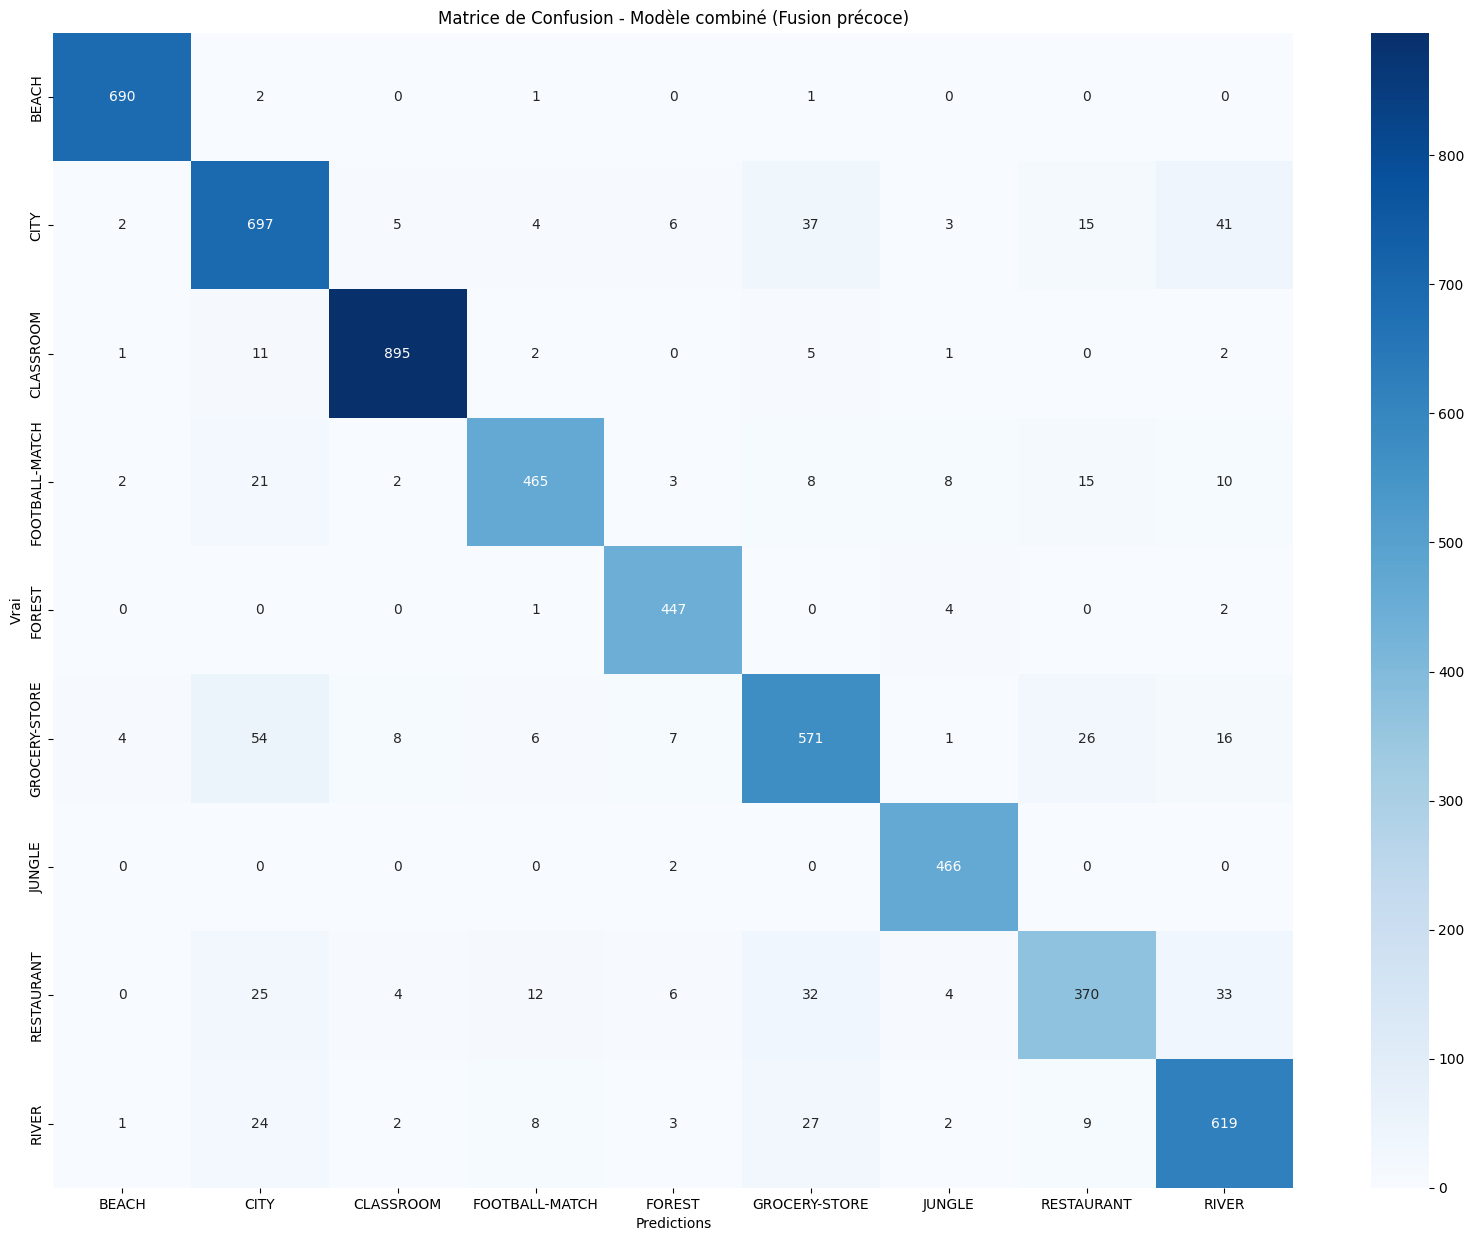

In [ ]:
# Calcul de la matrice de confusion pour le modèle combiné
cm_combined = confusion_matrix(y_test_encoded, y_pred_classes_combined)

# Affichage de la matrice de confusion
plt.figure(figsize=(20, 15))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Vrai')
plt.xlabel('Predictions')
plt.title('Matrice de Confusion - Modèle combiné (Fusion précoce)')
plt.show()

In [ ]:
# Prédictions sur les données de test (modèle combiné)
y_pred_combined = model_combined_dense.predict(X_test_combined)
y_pred_classes_combined = y_pred_combined.argmax(axis=1)  # Obtenir les classes prédites

# Décoder les classes numériques en labels textuels
y_pred_labels_combined = label_encoder.inverse_transform(y_pred_classes_combined)
y_true_labels_combined = label_encoder.inverse_transform(y_test_encoded)

# Créer un DataFrame pour afficher les résultats
results_df_combined = pd.DataFrame({'Image': test_df['IMAGE'],
                                    'Classe réelle': y_true_labels_combined,
                                    'Classe prédite': y_pred_labels_combined})

# Afficher la table
display(results_df_combined)

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Image,Classe réelle,Classe prédite
81,beach171.png,BEACH,BEACH
16686,venice-327.png,CITY,CITY
16040,store4-862.png,GROCERY-STORE,GROCERY-STORE
16389,vegas60.png,CITY,CITY
12791,river5-167.png,RIVER,RIVER
...,...,...,...
8057,forest936.png,FOREST,FOREST
4857,city12.png,CITY,CITY
8636,guangzhou-557.png,CITY,CITY
8173,guangzhou-14.png,CITY,GROCERY-STORE


In [ ]:
# Calcul du nombre de prédictions correctes et incorrectes (modèle combiné)
correct_predictions_combined = np.sum(y_test_encoded == y_pred_classes_combined)
incorrect_predictions_combined = len(y_test_encoded) - correct_predictions_combined

# Affichage des résultats
print(f"Modèle combiné (Fusion précoce) :")
print(f" - Prédictions correctes : {correct_predictions_combined}")
print(f" - Prédictions incorrectes : {incorrect_predictions_combined}")

Modèle combiné (Fusion précoce) :
 - Prédictions correctes : 5220
 - Prédictions incorrectes : 531


##### 3-2. Le modèle SVM

In [ ]:
from sklearn.svm import SVC

# Définir le modèle SVM
model_combined_svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) # probability=True for predict_proba

# Entraîner le modèle SVM
model_combined_svm.fit(X_train_combined, y_train_encoded)

# Enregistrer le modèle SVM
joblib.dump(model_combined_svm, '/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_SVM_Resnet.pkl')

['/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_SVM_Resnet.pkl']

In [ ]:
# Charger le modèle SVM
model_combined_svm = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_SVM.pkl')
model_combined_svm = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_SVM_Inception.pkl')
model_combined_svm = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_SVM_Resnet.pkl')

In [ ]:
# Obtenir les probabilités des prédictions
y_pred_svm_proba = model_combined_svm.predict_proba(X_test_combined)

# Obtenir les classes prédites (en utilisant argmax pour trouver la classe avec la probabilité la plus élevée)
y_pred_classes_svm = np.argmax(y_pred_svm_proba, axis=1)

In [ ]:
# Calcul des métriques pour le modèle SVM
precision_svm = precision_score(y_test_encoded, y_pred_classes_svm, average='weighted')
recall_svm = recall_score(y_test_encoded, y_pred_classes_svm, average='weighted')
f1_svm = f1_score(y_test_encoded, y_pred_classes_svm, average='weighted')

# Affichage des résultats
print(f"Précision (Modèle SVM): {precision_svm}\n")
print(f"Rappel (Modèle SVM): {recall_svm}\n")
print(f"F1-Score (Modèle SVM): {f1_svm}")

Précision (Modèle SVM): 0.9229423525236762

Rappel (Modèle SVM): 0.9193183794122761

F1-Score (Modèle SVM): 0.9197348432156496


In [ ]:
# Affichage du rapport de classification pour le modèle SVM
print("Rapport de classification (Modèle SVM) :\n")
print(classification_report(y_test_encoded, y_pred_classes_svm, target_names=target_names))

Rapport de classification (Modèle SVM) :

                precision    recall  f1-score   support

         BEACH       0.99      0.99      0.99       694
          CITY       0.86      0.88      0.87       810
     CLASSROOM       0.98      0.98      0.98       917
FOOTBALL-MATCH       0.95      0.88      0.92       534
        FOREST       0.95      0.98      0.97       454
 GROCERY-STORE       0.83      0.90      0.86       693
        JUNGLE       0.99      0.99      0.99       468
    RESTAURANT       0.84      0.82      0.83       486
         RIVER       0.92      0.88      0.90       695

      accuracy                           0.92      5751
     macro avg       0.92      0.92      0.92      5751
  weighted avg       0.92      0.92      0.92      5751



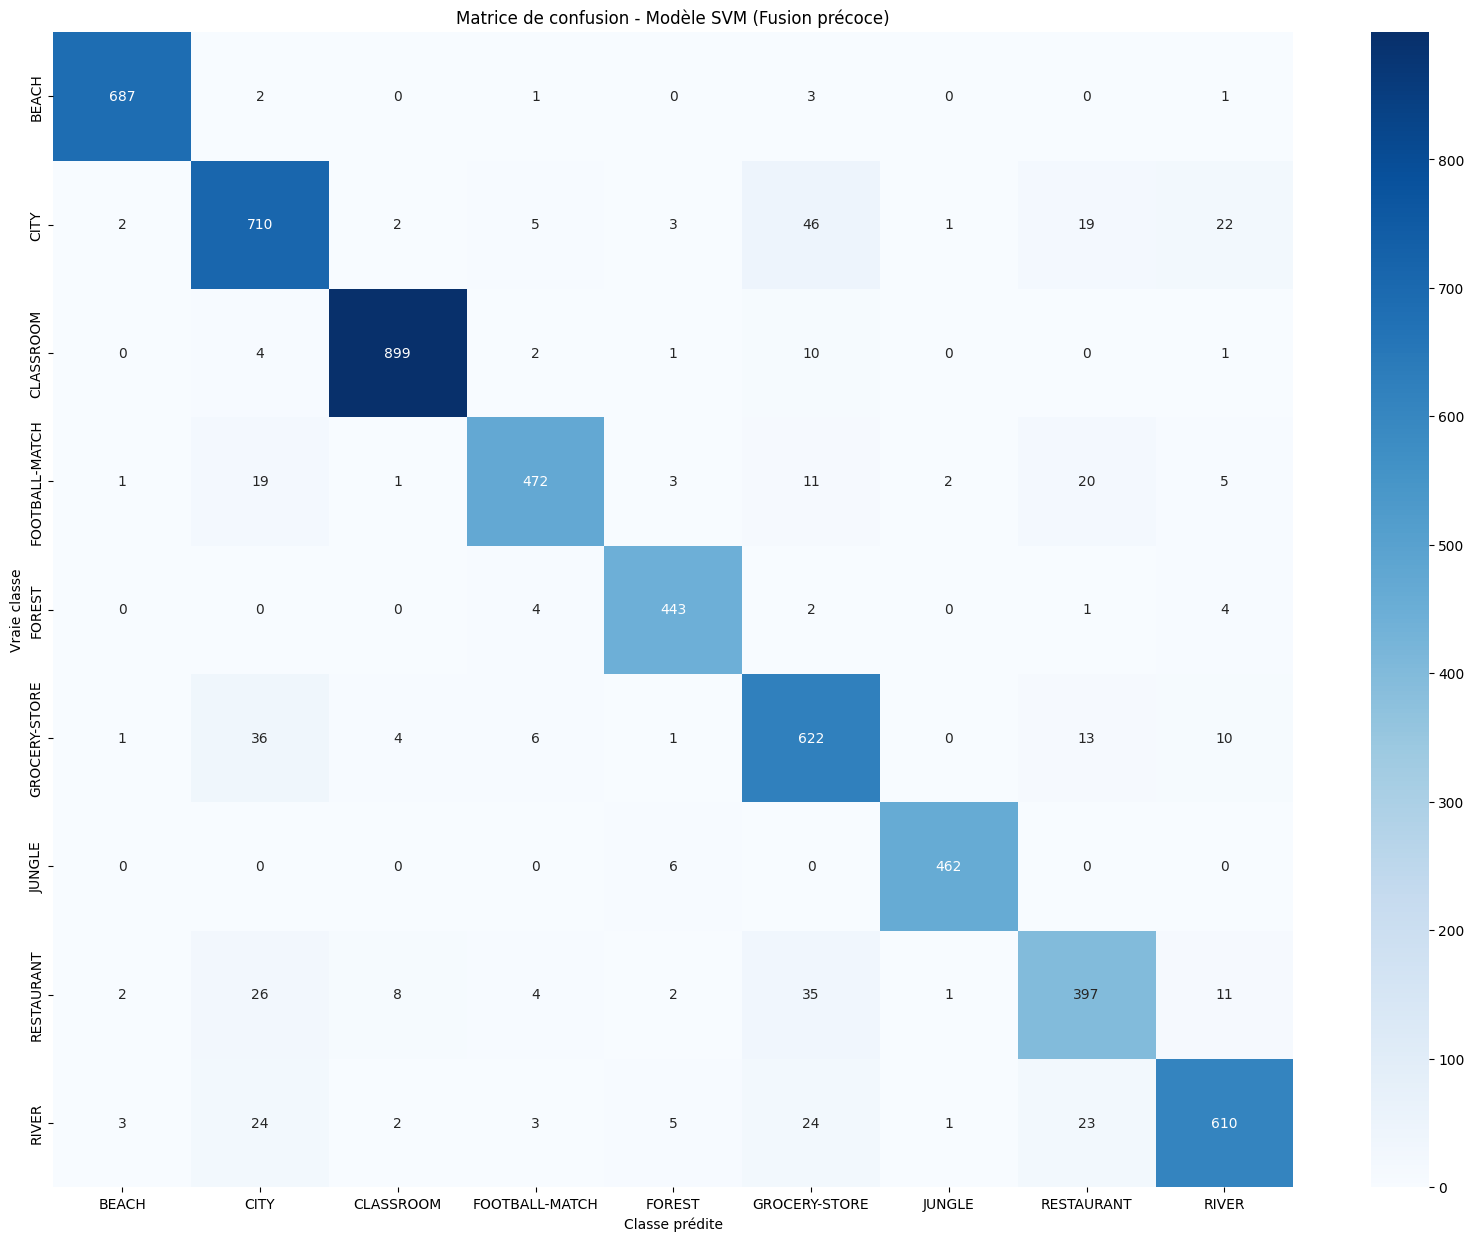

In [ ]:
# Calcul de la matrice de confusion pour le modèle SVM
cm_svm = confusion_matrix(y_test_encoded, y_pred_classes_svm)

# Affichage de la matrice de confusion
plt.figure(figsize=(20, 15))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion - Modèle SVM (Fusion précoce)')
plt.show()

In [ ]:
# Prédictions sur les données de test (modèle SVM)
y_pred_classes_svm = model_combined_svm.predict(X_test_combined)  # Obtenir les classes prédites

# Décoder les classes numériques en labels textuels
y_pred_labels_svm = label_encoder.inverse_transform(y_pred_classes_svm)

# Créer un DataFrame pour afficher les résultats
results_df_svm = pd.DataFrame({'Image': test_df['IMAGE'],
                                 'Classe réelle': y_true_labels_combined,
                                 'Classe prédite': y_pred_labels_svm})

# Afficher la table
display(results_df_svm)

,Image,Classe réelle,Classe prédite
81,beach171.png,BEACH,BEACH
16686,venice-327.png,CITY,GROCERY-STORE
16040,store4-862.png,GROCERY-STORE,GROCERY-STORE
16389,vegas60.png,CITY,CITY
12791,river5-167.png,RIVER,RIVER
...,...,...,...
8057,forest936.png,FOREST,FOREST
4857,city12.png,CITY,CITY
8636,guangzhou-557.png,CITY,CITY
8173,guangzhou-14.png,CITY,GROCERY-STORE


In [ ]:
# Calcul du nombre de prédictions correctes et incorrectes (modèle SVM)
correct_predictions_svm = np.sum(y_test_encoded == y_pred_classes_svm)
incorrect_predictions_svm = len(y_test_encoded) - correct_predictions_svm

# Affichage des résultats
print(f"Modèle SVM (Fusion précoce) :")
print(f" - Prédictions correctes : {correct_predictions_svm}")
print(f" - Prédictions incorrectes : {incorrect_predictions_svm}")

Modèle SVM (Fusion précoce) :
 - Prédictions correctes : 5287
 - Prédictions incorrectes : 464


##### 3-3. Le modèle Random Forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Définir le modèle Random Forest
model_combined_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle Random Forest
model_combined_rf.fit(X_train_combined, y_train_encoded)

# Enregistrer le modèle Random Forest
joblib.dump(model_combined_rf, '/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_RF_Resnet.pkl')

['/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_RF_Resnet.pkl']

In [ ]:
# Charger le modèle Random Forest
model_combined_rf = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_RF.pkl')
model_combined_rf = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_RF_Inception.pkl')
model_combined_rf = joblib.load('/content/drive/MyDrive/Multimodale/Model/Modele_Precoce_RF_Resnet.pkl')

In [ ]:
# Obtenir les probabilités des prédictions
y_pred_rf_proba = model_combined_rf.predict_proba(X_test_combined)

# Obtenir les classes prédites
y_pred_classes_rf = np.argmax(y_pred_rf_proba, axis=1)

In [ ]:
# Calcul des métriques pour le modèle Random Forest
precision_rf = precision_score(y_test_encoded, y_pred_classes_rf, average='weighted')
recall_rf = recall_score(y_test_encoded, y_pred_classes_rf, average='weighted')
f1_rf = f1_score(y_test_encoded, y_pred_classes_rf, average='weighted')

# Affichage des résultats
print(f"Précision (Modèle Random Forest): {precision_rf}\n")
print(f"Rappel (Modèle Random Forest): {recall_rf}\n")
print(f"F1-Score (Modèle Random Forest): {f1_rf}")

Précision (Modèle Random Forest): 0.8922797596047037

Rappel (Modèle Random Forest): 0.8838462876021561

F1-Score (Modèle Random Forest): 0.8851742926812992


In [ ]:
# Affichage du rapport de classification pour le modèle Random Forest
print("Rapport de classification (Modèle Random Forest) :\n")
print(classification_report(y_test_encoded, y_pred_classes_rf, target_names=target_names))

Rapport de classification (Modèle Random Forest) :

                precision    recall  f1-score   support

         BEACH       0.99      0.99      0.99       694
          CITY       0.81      0.84      0.83       810
     CLASSROOM       0.99      0.97      0.98       917
FOOTBALL-MATCH       0.91      0.78      0.84       534
        FOREST       0.86      0.89      0.88       454
 GROCERY-STORE       0.70      0.88      0.78       693
        JUNGLE       0.93      0.97      0.95       468
    RESTAURANT       0.84      0.75      0.79       486
         RIVER       0.97      0.83      0.90       695

      accuracy                           0.88      5751
     macro avg       0.89      0.88      0.88      5751
  weighted avg       0.89      0.88      0.89      5751



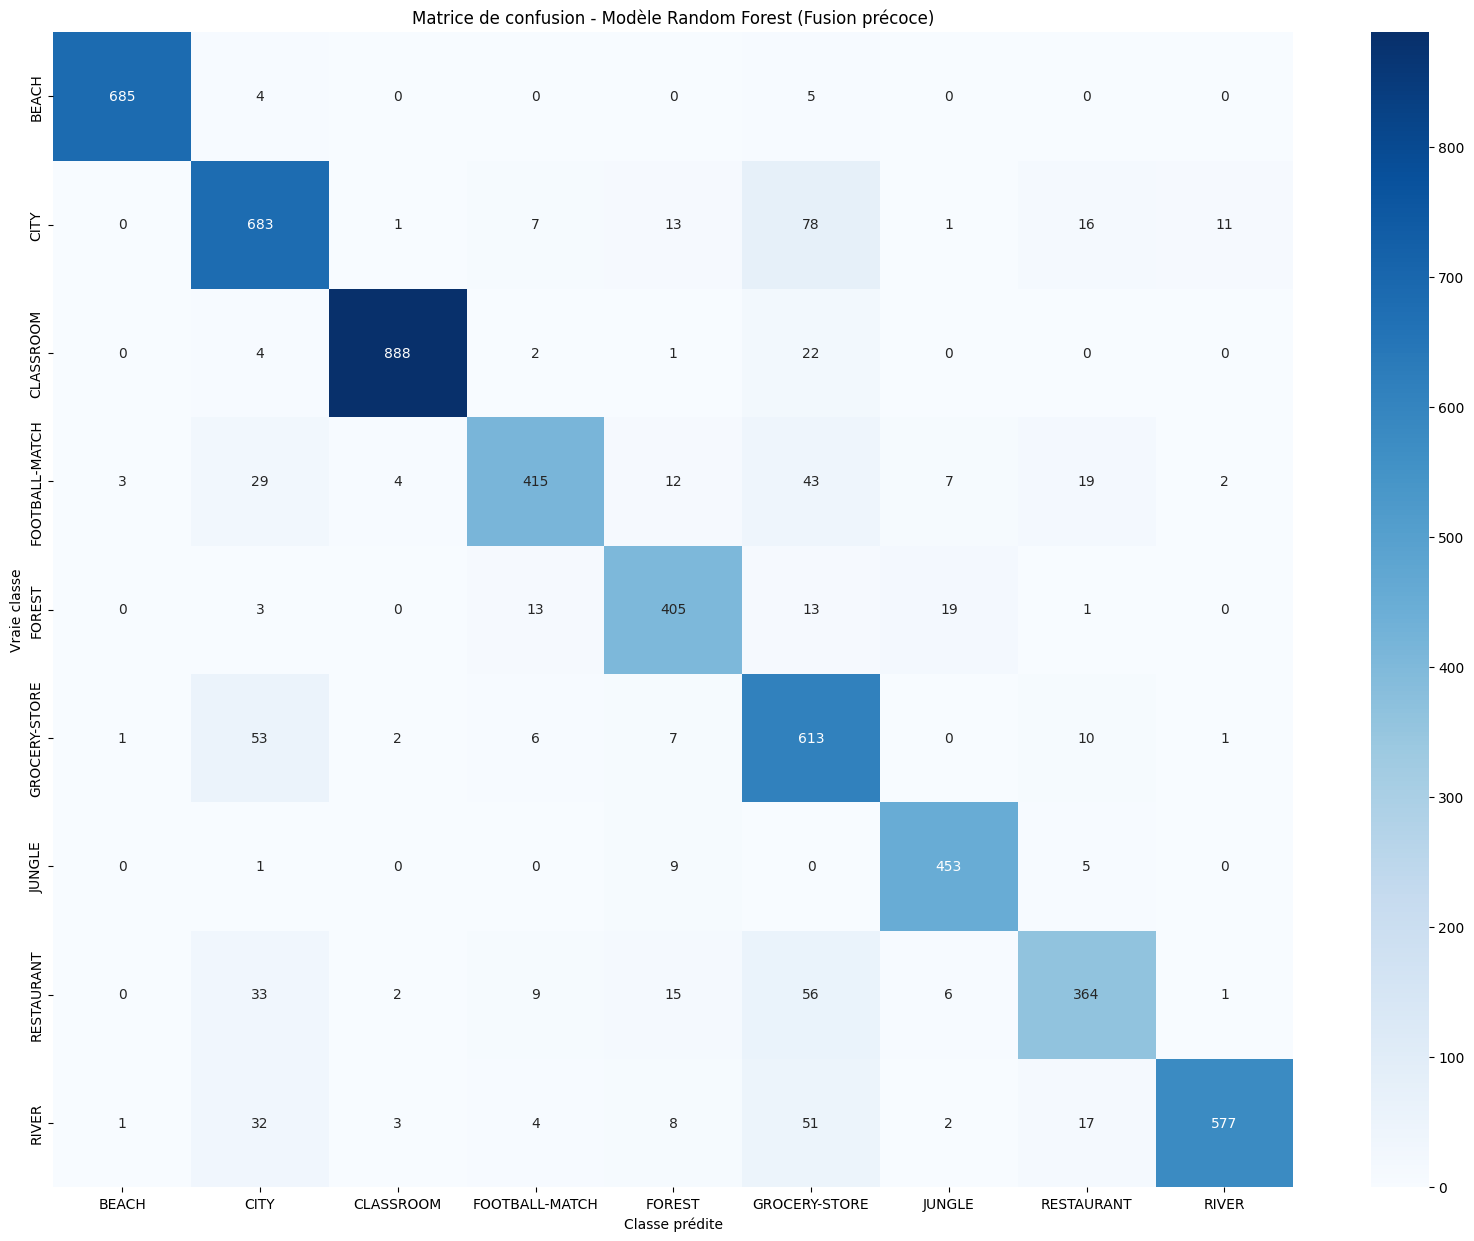

In [ ]:
# Calcul de la matrice de confusion pour le modèle Random Forest
cm_rf = confusion_matrix(y_test_encoded, y_pred_classes_rf)

# Affichage de la matrice de confusion
plt.figure(figsize=(20, 15))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion - Modèle Random Forest (Fusion précoce)')
plt.show()

In [ ]:
# Prédictions sur les données de test (modèle Random Forest)
y_pred_classes_rf = model_combined_rf.predict(X_test_combined)  # Obtenir les classes prédites

# Décoder les classes numériques en labels textuels
y_pred_labels_rf = label_encoder.inverse_transform(y_pred_classes_rf)

# Créer un DataFrame pour afficher les résultats
results_df_rf = pd.DataFrame({'Image': test_df['IMAGE'],
                                 'Classe réelle': y_true_labels_combined,
                                 'Classe prédite': y_pred_labels_rf})

# Afficher la table
display(results_df_rf)

,Image,Classe réelle,Classe prédite
81,beach171.png,BEACH,BEACH
16686,venice-327.png,CITY,GROCERY-STORE
16040,store4-862.png,GROCERY-STORE,GROCERY-STORE
16389,vegas60.png,CITY,CITY
12791,river5-167.png,RIVER,RIVER
...,...,...,...
8057,forest936.png,FOREST,FOREST
4857,city12.png,CITY,CITY
8636,guangzhou-557.png,CITY,CITY
8173,guangzhou-14.png,CITY,GROCERY-STORE


In [ ]:
# Calcul du nombre de prédictions correctes et incorrectes (modèle Random Forest)
correct_predictions_rf = np.sum(y_test_encoded == y_pred_classes_rf)
incorrect_predictions_rf = len(y_test_encoded) - correct_predictions_rf

# Affichage des résultats
print(f"Modèle Random Forest (Fusion précoce) :")
print(f" - Prédictions correctes : {correct_predictions_rf}")
print(f" - Prédictions incorrectes : {incorrect_predictions_rf}")

Modèle Random Forest (Fusion précoce) :
 - Prédictions correctes : 5083
 - Prédictions incorrectes : 668
